# The Python Control Flow Graph

In [1]:
import ast
import re
import astunparse

import graphviz
from graphviz import Digraph
from IPython.display import SVG, display


In [2]:
def get_color(p, c):
    color='black'
    while not p.annotation():
        if p.label == 'if:True':
            return 'blue'
        elif p.label == 'if:False':
            return 'red'
        p = p.parents[0]
    return color

def get_peripheries(p):
    annot = p.annotation()
    if annot  in {'<start>', '<stop>'}:
        return '2'
    if annot.startswith('<define>') or annot.startswith('<exit>'):
        return '2'
    return '1'

def get_shape(p):
    annot = p.annotation()
    if annot in {'<start>', '<stop>'}:
        return 'oval'
    if annot.startswith('<define>') or annot.startswith('<exit>'):
        return 'oval'

    if annot.startswith('if:'):
        return 'diamond'
    else:
        return 'rectangle'


def to_graph(registry, arcs=[], comment='', get_shape=lambda n: 'rectangle', get_peripheries=lambda n: '1', get_color=lambda p,c: 'black'):
    graph = Digraph(comment=comment)
    for nid, cnode in registry.items():
        if not cnode.annotation():
            continue
        sn = cnode.annotation()
        graph.node(cnode.name(), sn, shape=get_shape(cnode), peripheries=get_peripheries(cnode))
        for pn in cnode.parents:
            gp = pn.get_gparent_id()
            color = get_color(pn, cnode)
            graph.edge(gp, str(cnode.rid), color=color)
    return graph


The CFGNode

The control flow graph is a graph, and hence we need a data structue for the node. We need to store the parents of this node, the children of this node, and register itself in the registery.

In [3]:
class CFGNode:
    counter = 0
    registry = {}
    stack = []
    def __init__(self, parents=[], ast=None, label=None, annot=None):
        self.parents = parents
        self.calls = []
        self.children = []
        self.ast_node = ast
        self.label = label
        self.annot = annot
        self.rid  = CFGNode.counter
        CFGNode.registry[self.rid] = self
        CFGNode.counter += 1


Given that it is a directed graph node, we need the ability to add parents and children.

class CFGNode(CFGNode):

In [4]:
class CFGNode(CFGNode):
    def add_child(self, c):
        if c not in self.children:
            self.children.append(c)

    def add_parent(self, p):
        if p not in self.parents:
            self.parents.append(p)

    def add_parents(self, ps):
        for p in ps:
            self.add_parent(p)

    def add_calls(self, func):
        mid = None
        if hasattr(func, 'id'): # ast.Name
            mid = func.id
        else: # ast.Attribute
            mid = func.value.id
        self.calls.append(mid)

        

A few convenience methods to make our life simpler.

In [5]:
class CFGNode(CFGNode):
    def __eq__(self, other):
        return self.rid == other.rid

    def __neq__(self, other):
        return self.rid != other.rid

    def lineno(self):
        return self.ast_node.lineno if hasattr(self.ast_node, 'lineno') else 0
        
    def name(self):
        return str(self.rid)
        
    def expr(self):
        return self.source()
        
    def __str__(self):
        return "id:%d line[%d] parents: %s : %s" % \
           (self.rid, self.lineno(), str([p.rid for p in self.parents]), self.source())

    def __repr__(self):
        return str(self)

    def source(self):
        return astunparse.unparse(self.ast_node).strip()

    def annotation(self):
        if self.annot is not None:
            return self.annot
        return self.source()

    def to_json(self):
        return {'id':self.rid, 'parents': [p.rid for p in self.parents],
               'children': [c.rid for c in self.children],
               'calls': self.calls, 'at':self.lineno() ,'ast':self.source()}
               
    def get_gparent_id(self):
        p = CFGNode.registry[self.rid]
        while not p.annotation():
            p = p.parents[0]
        return str(p.rid)


The usage is as below:

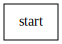

In [6]:
start = CFGNode(parents=[], ast=ast.parse('start').body)
g = to_graph(CFGNode.registry, get_color=get_color, get_peripheries=get_peripheries, get_shape=get_shape)
g.format = 'svg'
#print(g.pipe().decode())
display(SVG(g.pipe().decode()))

In [7]:
class PyCFGExtractor:
    def __init__(self):
        self.founder = CFGNode(parents=[], ast=ast.parse('start').body[0]) # sentinel
        self.founder.ast_node.lineno = 0
        self.functions = {}
        self.functions_node = {}


In [8]:
class PyCFGExtractor(PyCFGExtractor):
    def walk(self, node, myparents):
        if node is None: return
        fname = "on_%s" % node.__class__.__name__.lower()
        if hasattr(self, fname):
            return getattr(self, fname)(node, myparents)
        raise SyntaxError('walk: Not Implemented in %s' % type(node))


In [9]:
class PyCFGExtractor(PyCFGExtractor):
    def on_pass(self, node, myparents):
        p = [CFGNode(parents=myparents, ast=node)]
        return p
